# Data Literacy 
**University of Tübingen, Winter Term 2019/20, Kay Nieselt & Philipp Hennig**
## Exercise Sheet #10 — PCA

The goal of this sheet is to understand PCA. First we do the derivation of PCA and then we apply it to a "real-world" data (LFW face [1]). Furthermore, we will look into the problem that PCA has in the context of fairness [2].

1. http://vis-www.cs.umass.edu/lfw/
2. https://papers.nips.cc/paper/8294-the-price-of-fair-pca-one-extra-dimension

### Exercise 1: An application of PCA



To recap, the algorithm for computing the projection matrix $\mathbf{U}$ containing $k$ principal components above is given by

1. Compute the mean $\bar{\mathbf{x}} := \frac{1}{N} \sum_{n=1}^N \mathbf{x}_n$.
2. Compute the centered data matrix $\hat{\mathbf{X}} := (\mathbf{x}_1 - \bar{\mathbf{x}}, \dots, \mathbf{x}_N - \bar{\mathbf{x}})^\top$
2. Compute the covariance matrix $\mathbf{S} = \frac{1}{N} \hat{\mathbf{X}}^\top \hat{\mathbf{X}}$.
3. Do eigendecomposition or SVD on the covariance $\mathbf{C} = \mathbf{Q} \, \mathrm{diag}(\mathbf{\lambda}) \, \mathbf{Q}^\top$.
4. Pick $k$ columns of $\mathbf{Q}$ corresponding to the $k$ largest eigenvalues in $\mathbf{\lambda}$, and arrange them as a matrix $\mathbf{U}$.

Now, download the dataset from
https://drive.google.com/file/d/1oj6BwlPHZap4qYPGdGKObBzEXcPiuY9Y/view?usp=sharing.

Load the LFW images (in the `images` directory) into a matrix $\mathbf{X} \in \mathbb{R}^{13232 \times 1764}$, where each row contains an image vector. **Important:** Make sure to put the images into the correct row of $\mathbf{X}$. E.g. if the image file name is `img517.txt`, then put it in the $518$th row of $\mathbf{X}$. In particular note that the index starts from $0$.

In [2]:
import numpy as np

data = []
N    = 13232
for i in range(N):
    line = np.genfromtxt('data/images/img'+str(i)+'.txt', delimiter="\t")
    data.append( line[:,:-1].flatten() )
    
all_faces = np.array(data)
all_faces.shape

(13232, 1764)

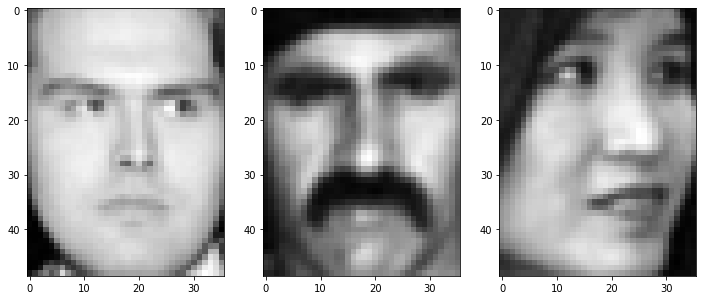

In [3]:
from matplotlib import pyplot as plt

def show(lines):
    n = len(lines)
    fig=plt.figure(figsize=(n*4, 12))
    for i, img in enumerate(lines):
        fig.add_subplot(1, n, i+1)
        plt.imshow(img.reshape((49,36)), cmap='gray')
    plt.show()

show([all_faces[2],all_faces[3],all_faces[4]])

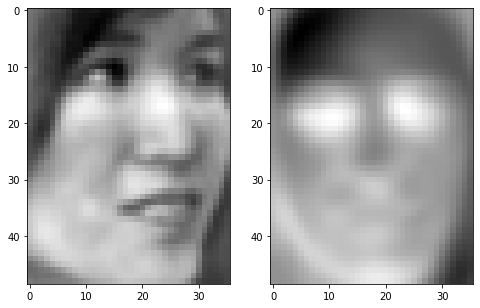

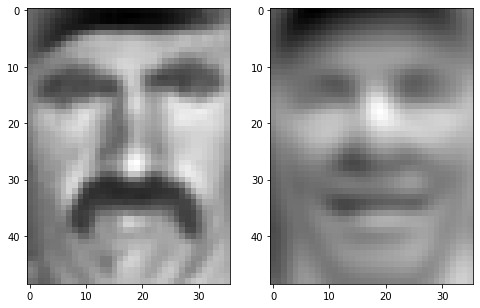

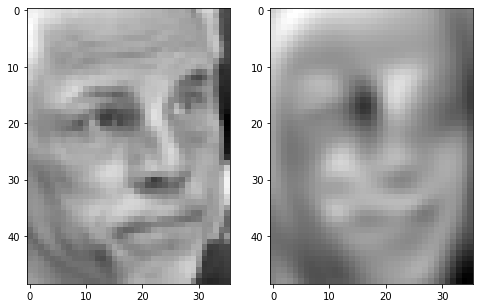

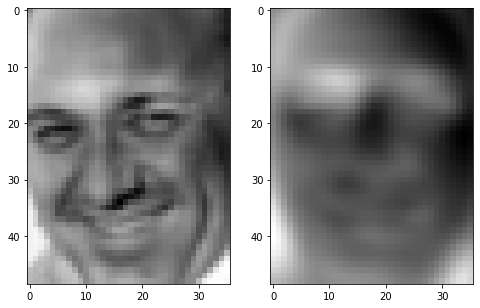

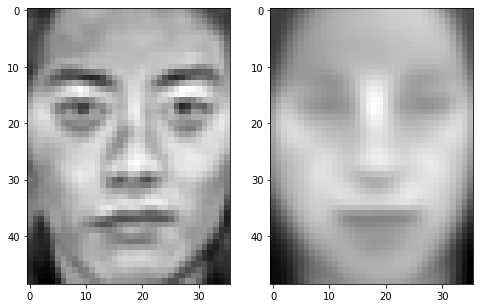

In [5]:
def PCA(dataset):
    dataset -= np.mean(dataset, axis=0)
    S = dataset.transpose() @ dataset / N
    values, vectors = np.linalg.eig(S)
    idx     = values.argsort()[::-1]   
    values  = values[idx]
    return vectors[:,idx]

def reconstruction(dataset, eigvectors, k=20):
    U = eigvectors[:,:k]
    return dataset @ U @ U.transpose()

eigvectors = PCA(all_faces)
rec_faces  = reconstruction(all_faces, eigvectors, k=20)

for i in [4,3,134,1200,1201]:
    show([ all_faces[i], rec_faces[i] ])

Pick different $k$ and plot as before. What do you notice?

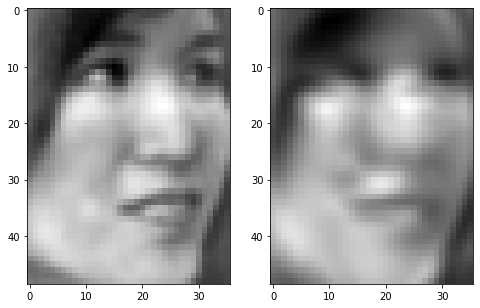

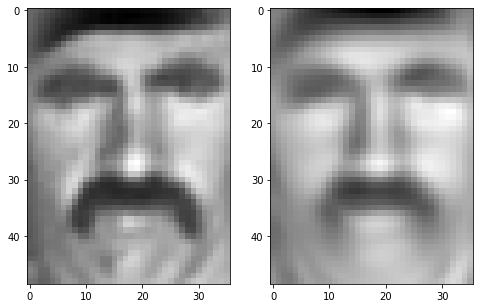

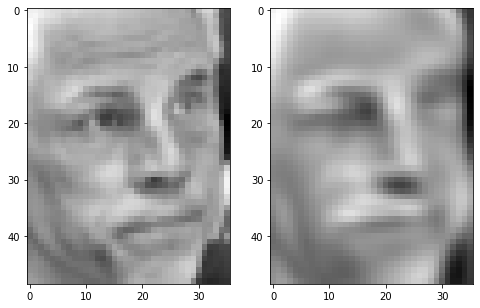

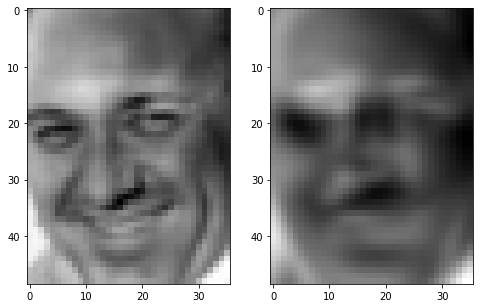

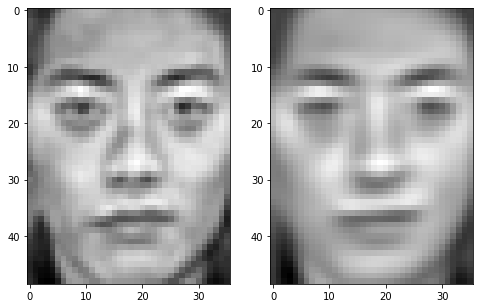

In [30]:
X = reconstruction(all_faces, eigvectors, k=100)
for i in [4,3,134,1200,1201]:
    show([all_faces[i],X[i]])


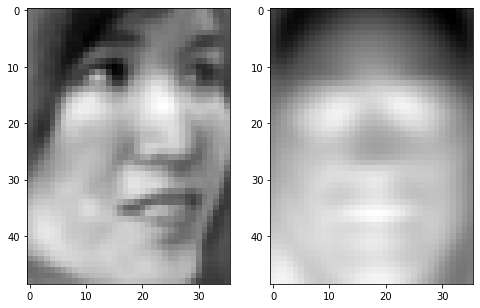

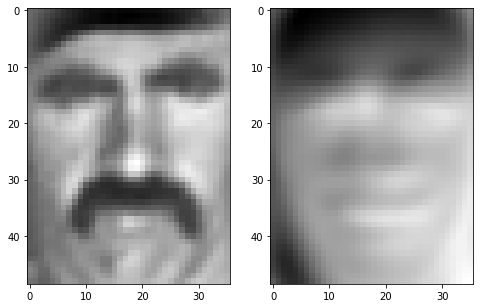

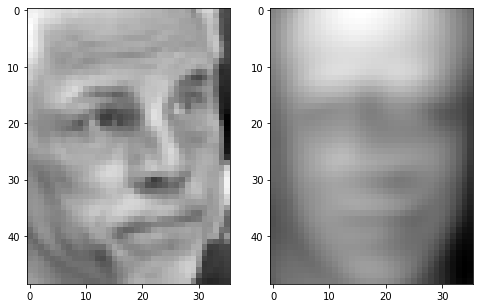

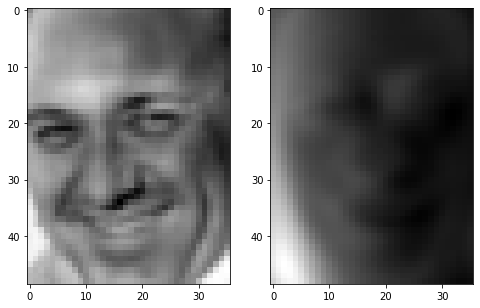

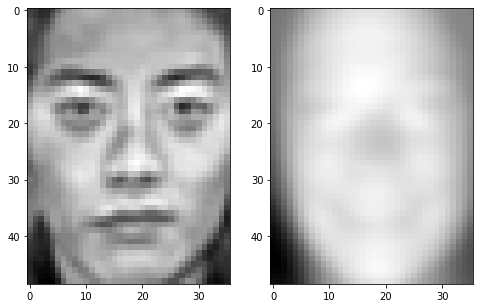

In [31]:
X = reconstruction(all_faces, eigvectors, k=5)
for i in [4,3,134,1200,1201]:
    show([all_faces[i],X[i]])

Finally, plot the reconstruction error w.r.t. the number of principal components.

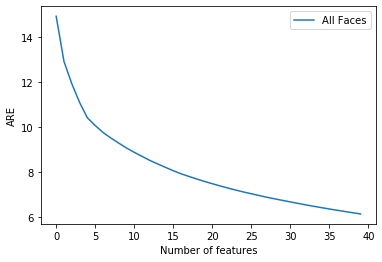

In [8]:
def ARE(dataset, eigvectors, label, features):  
    AREs  = []
    for k in range(features):
        X = reconstruction(dataset, eigvectors, k=k)
        AREs.append( np.linalg.norm(dataset - X)/len(dataset) )
    
    plt.plot(AREs, label=label)
    return np.array(AREs)
    
def AREplot():
    plt.ylabel('ARE')
    plt.xlabel('Number of features')
    plt.legend()
    plt.show()

ARE(all_faces, eigvectors, 'All Faces', 40)
AREplot()

### In Between Analysis

Lets analyse the different eigenvectors of the dataset. Which components play a major role? Here I print the ten first Principal components. Each of them encodes a feature.

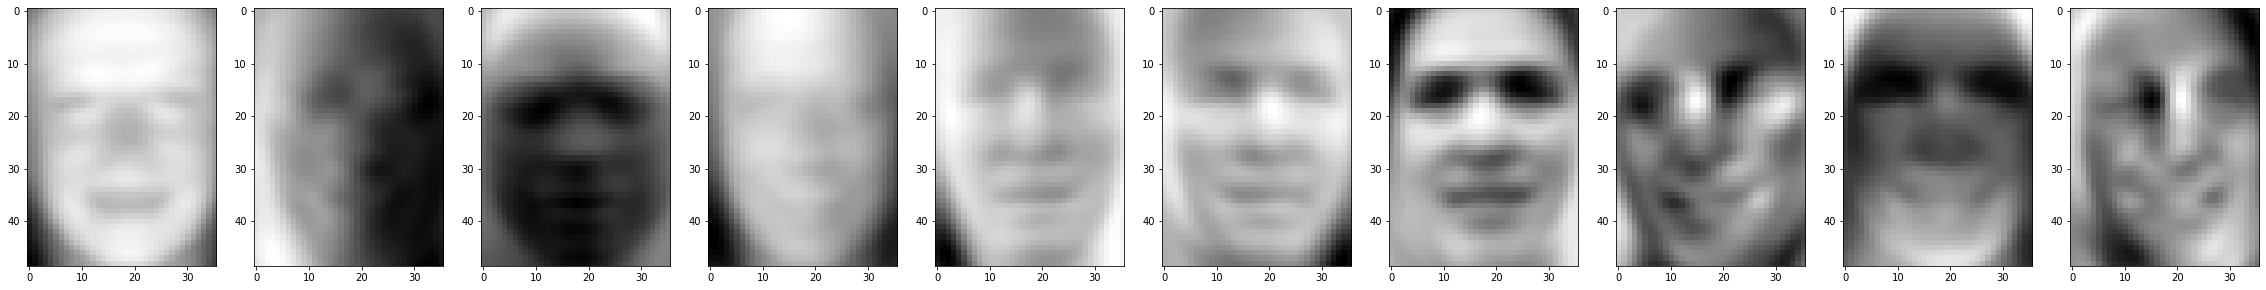

In [33]:
PCs = [eigvectors[:,i] for i in range(200)]
show(PCs[:10])

Its also interesting, how the reconstruction of an image changes over k. Lets call that the evolution of an image. In the beginning its just a black face, then it evolves...

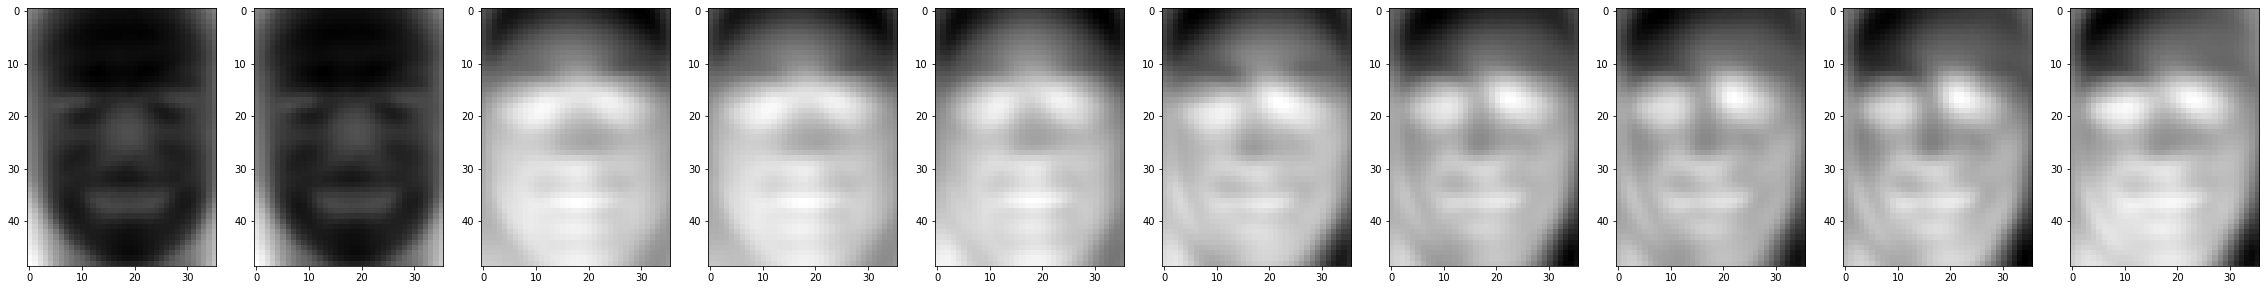

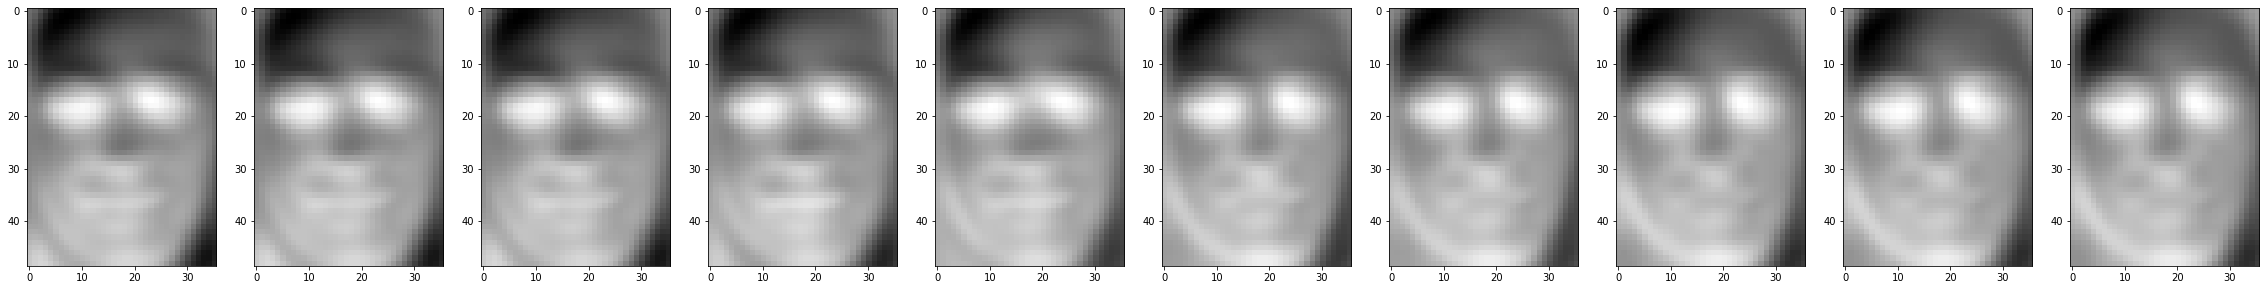

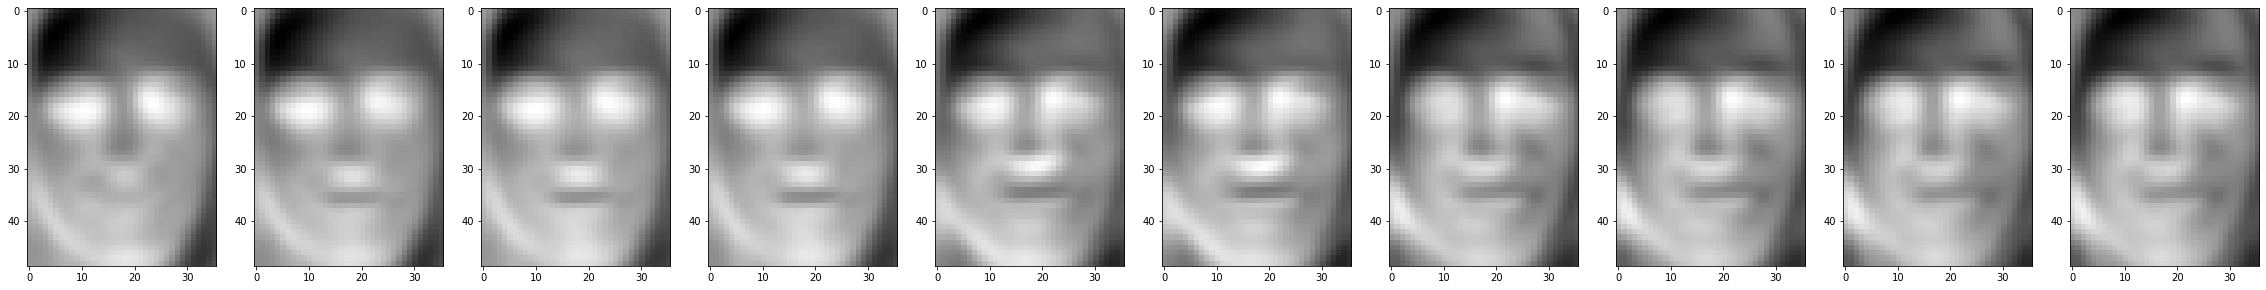

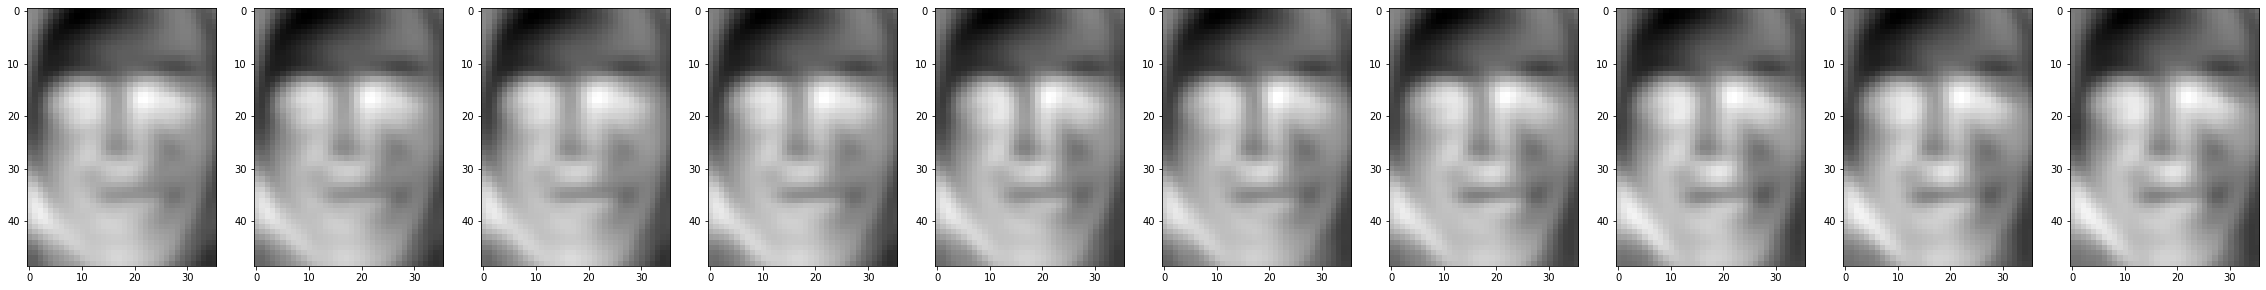

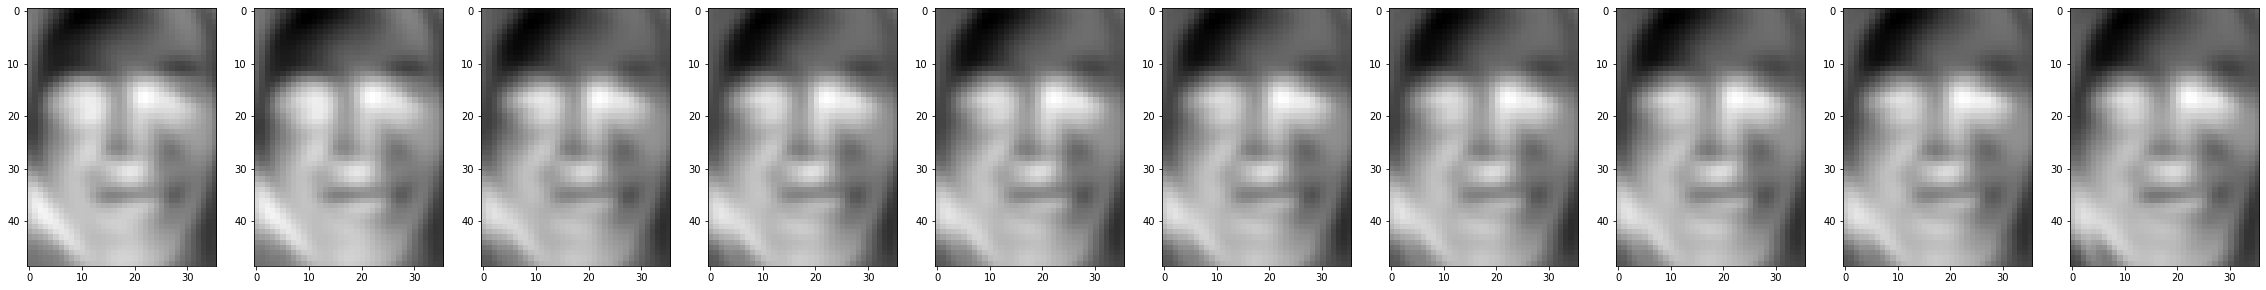

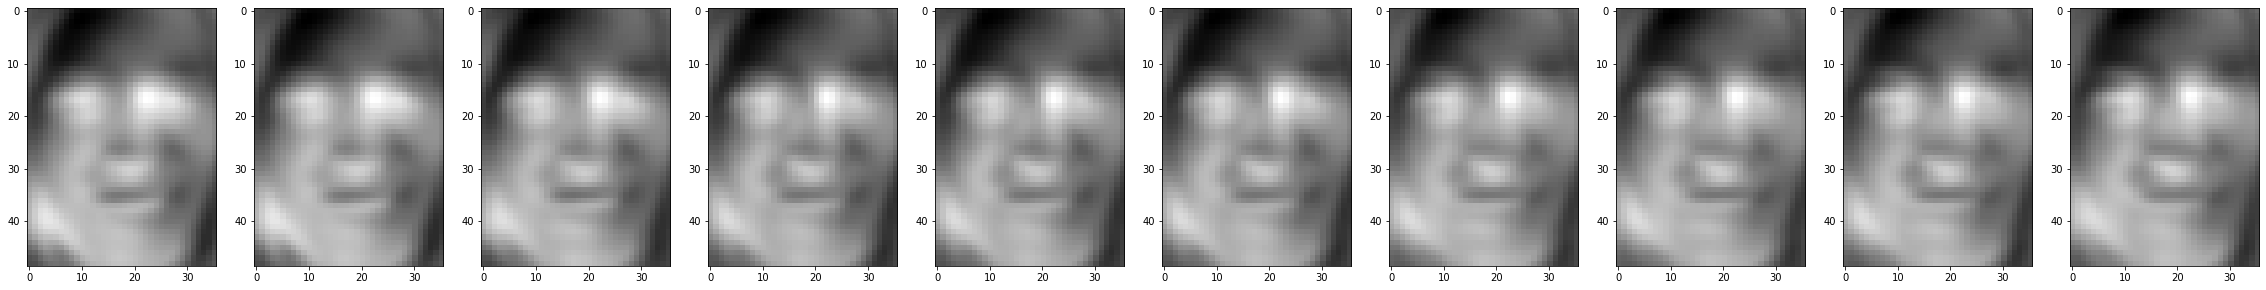

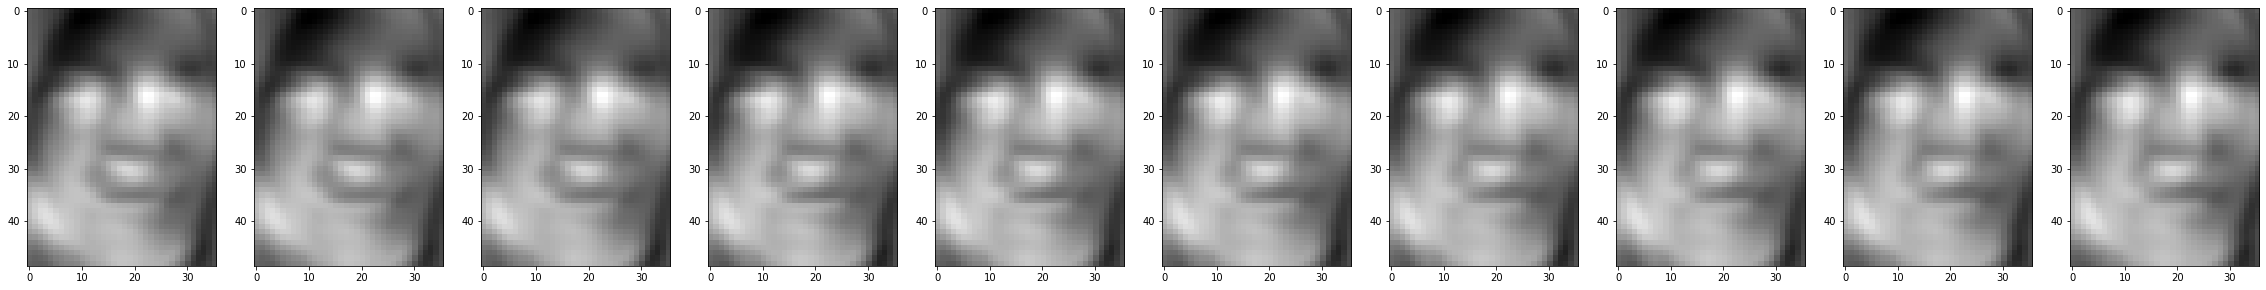

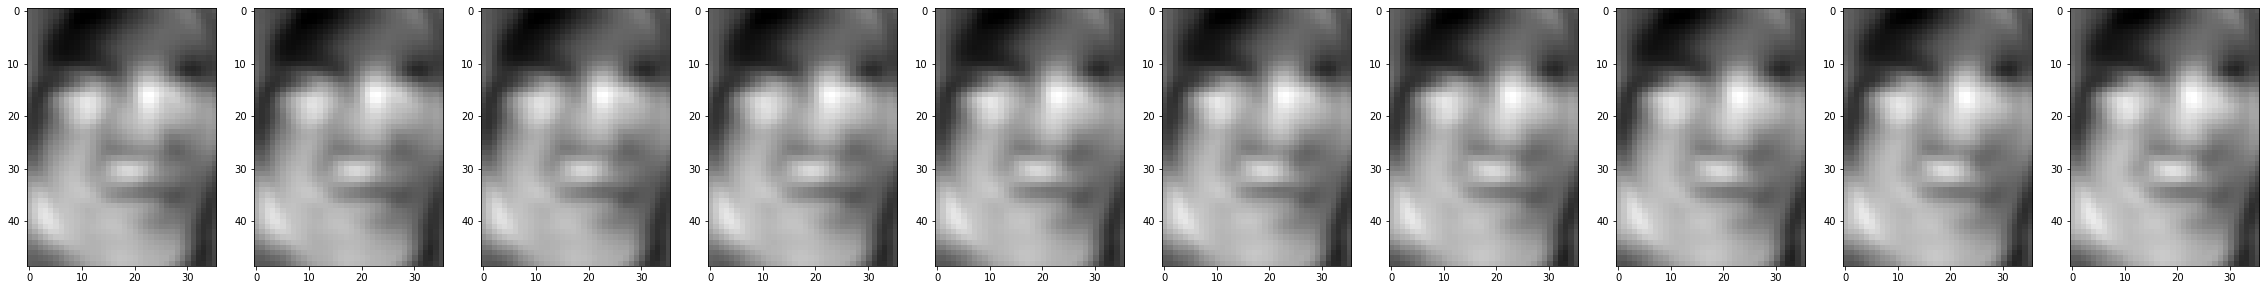

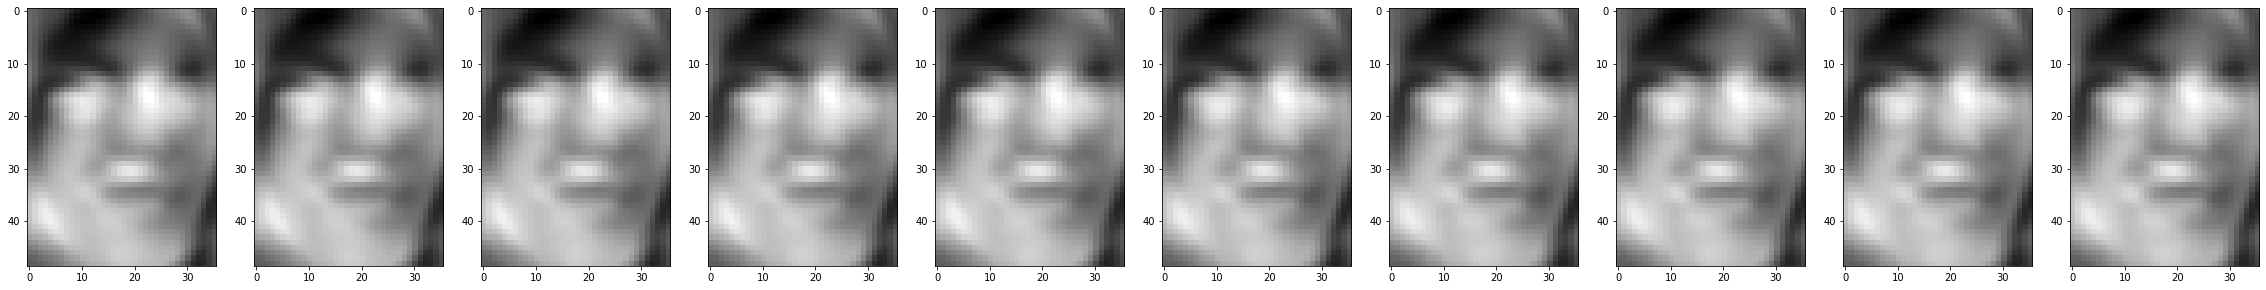

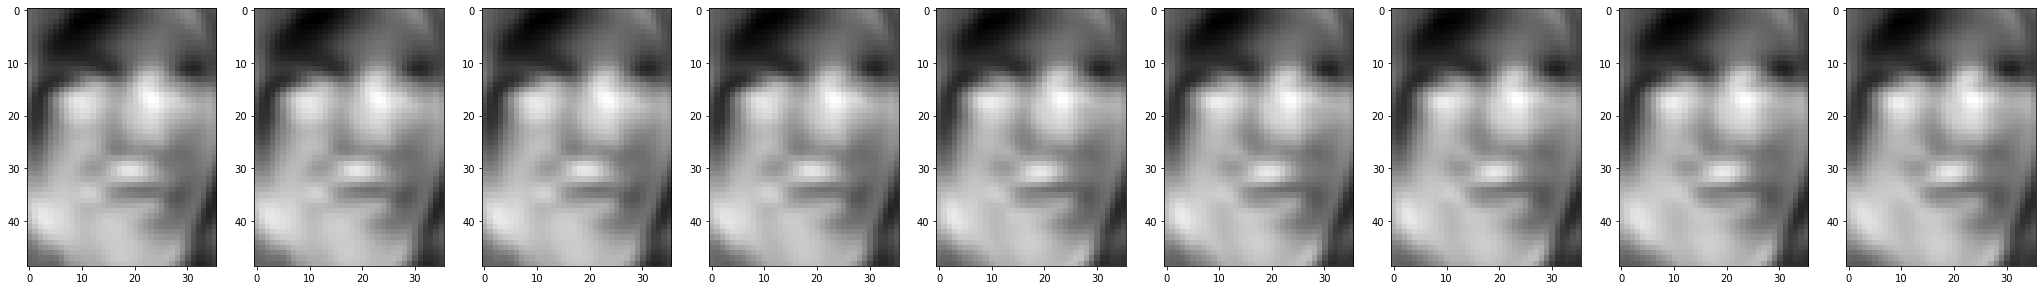

In [34]:
def evolution(line, K=100):
    projection = [ line @ np.outer(v, v) for v in PCs]
    evolution = [ np.sum( projection[:k], axis=0) for k in range(1,K) ]
    for i in range(0,K,10):
        show(evolution[i:i+10])
        
evolution(all_faces[4])    ### FEMALE

REMARK: Notice how she slowly turns her head

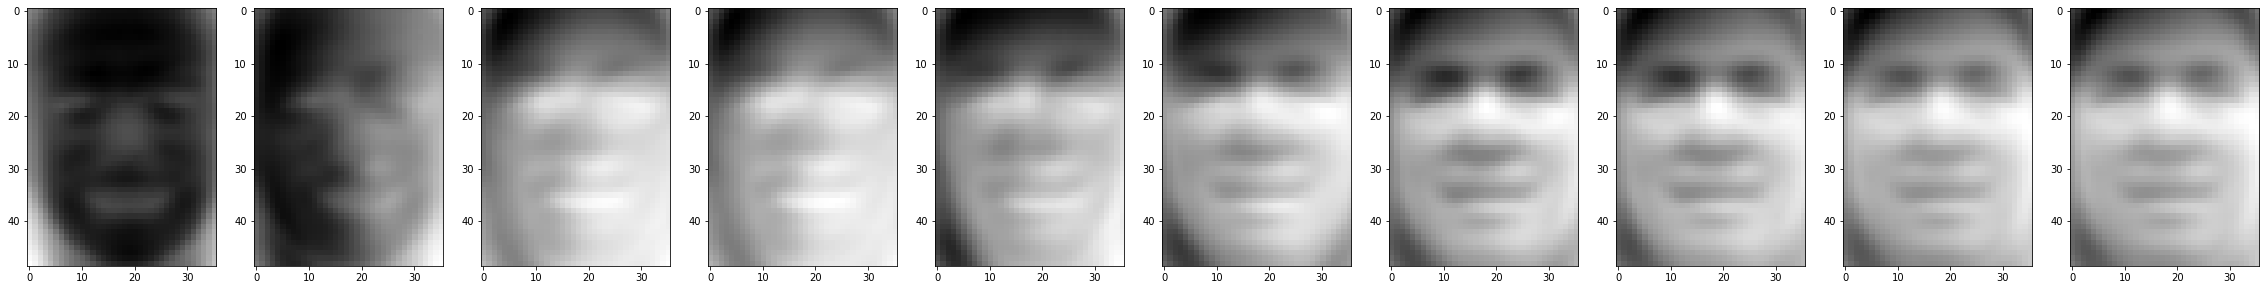

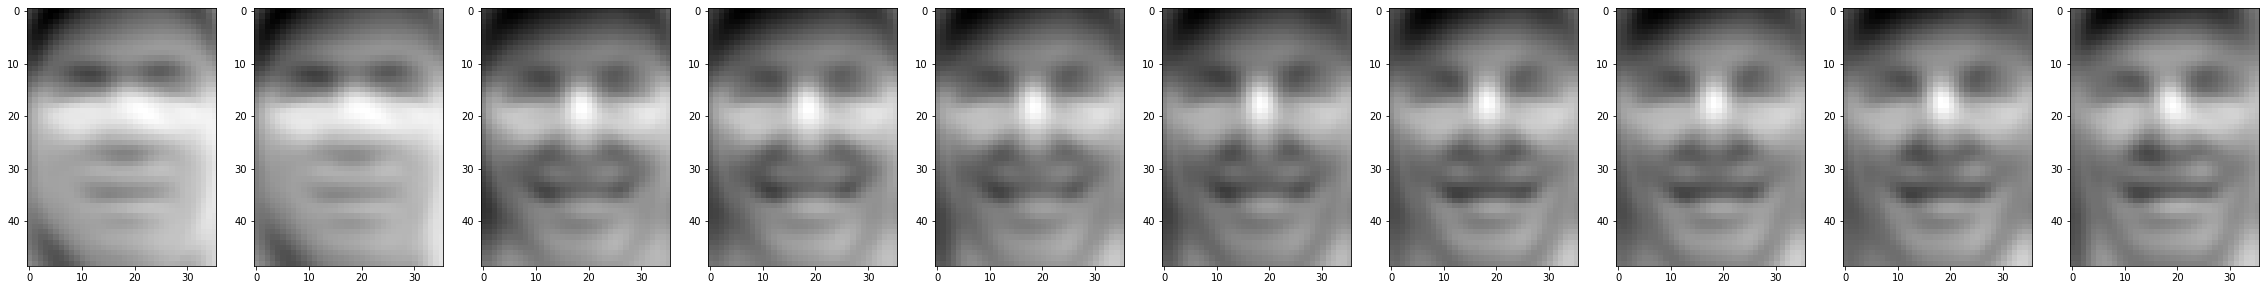

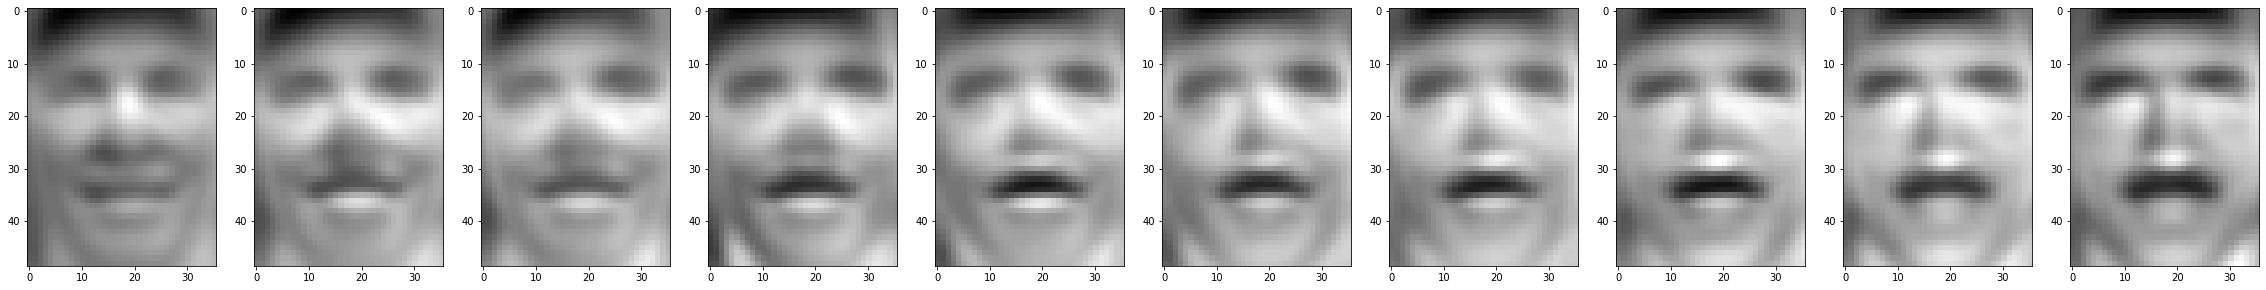

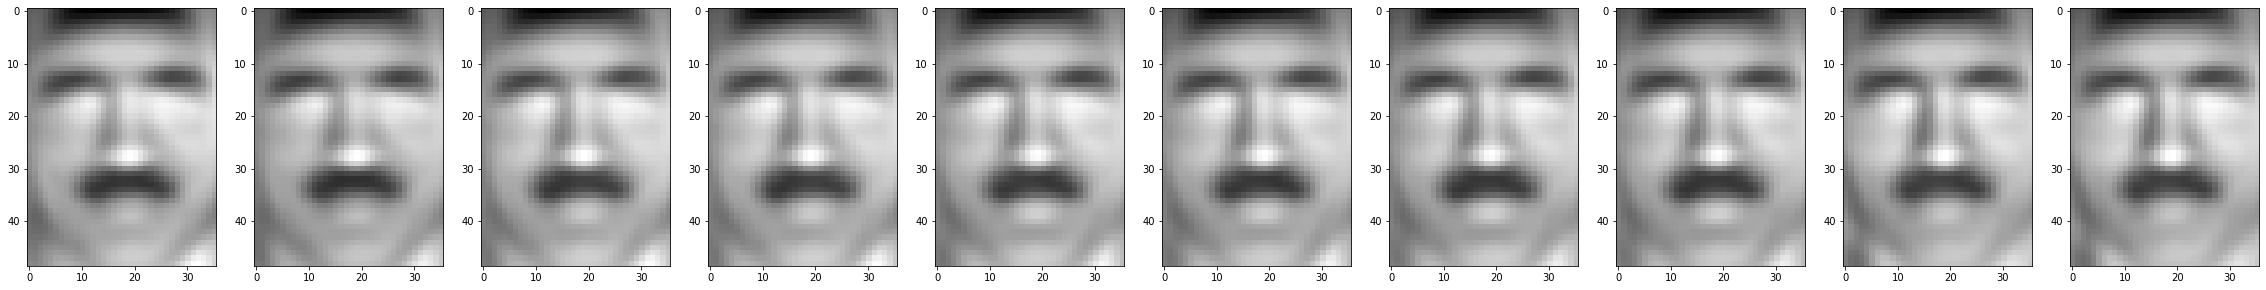

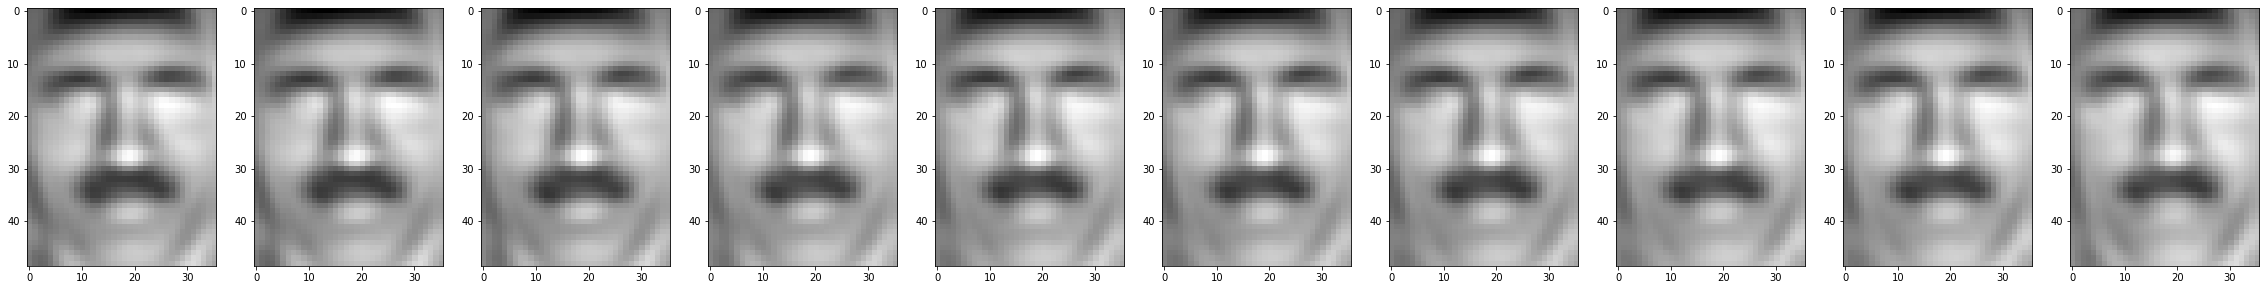

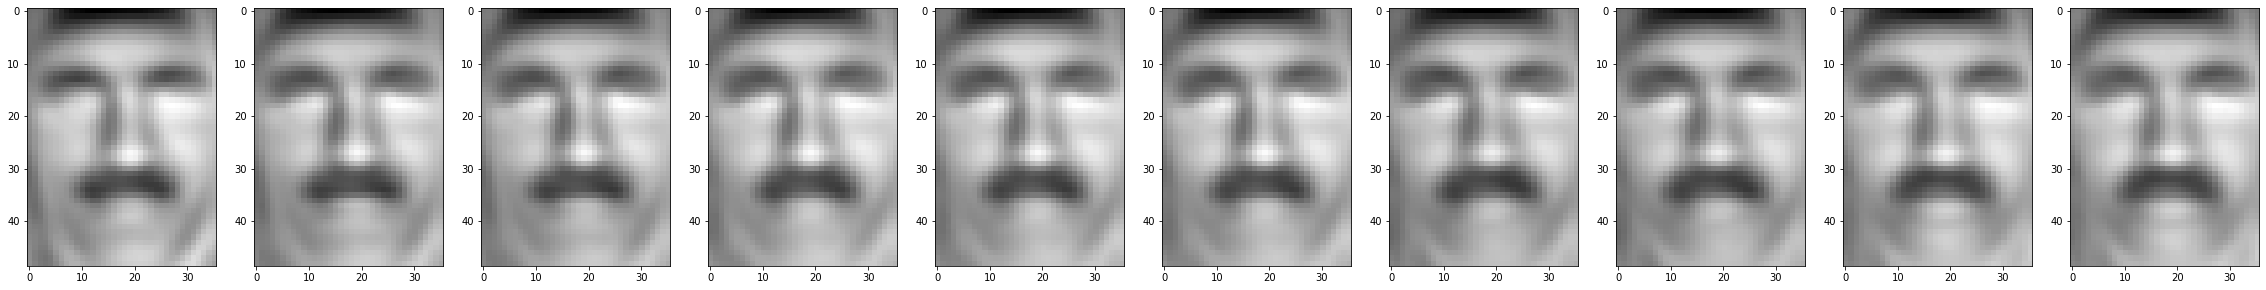

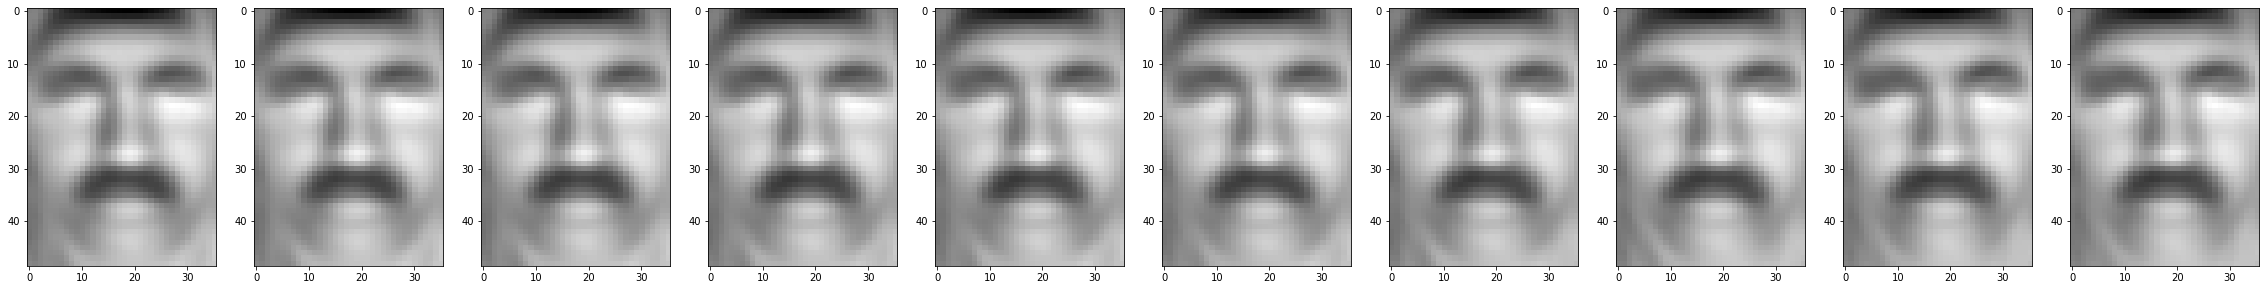

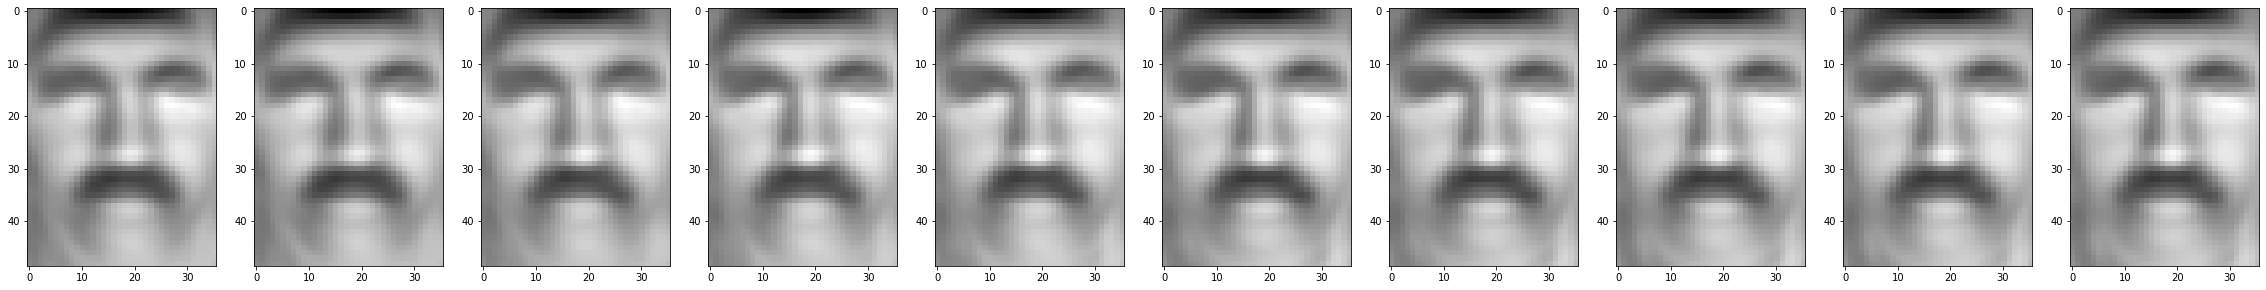

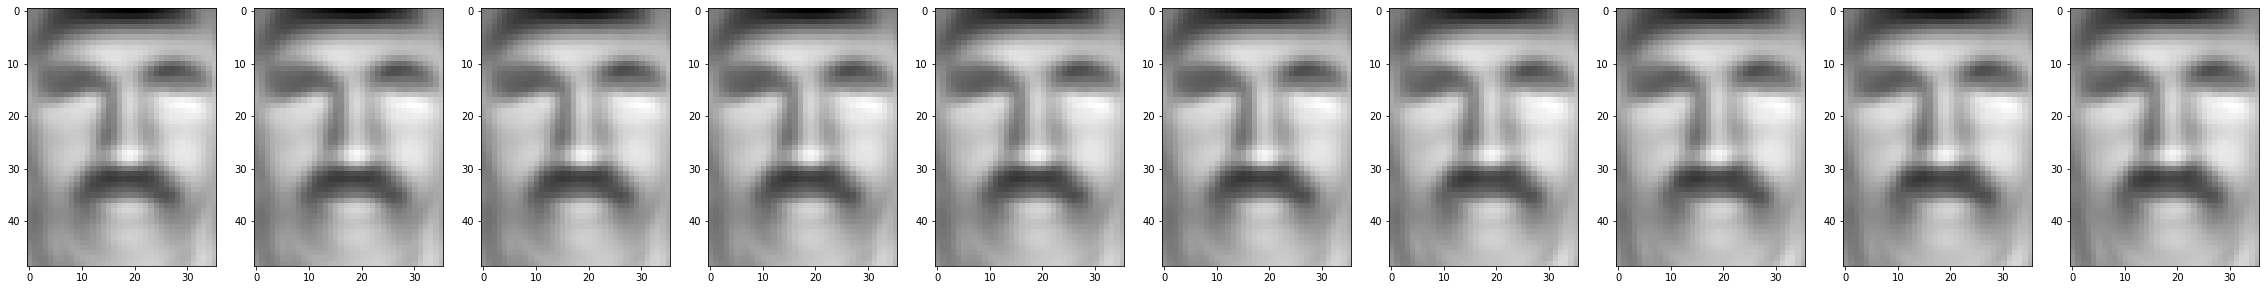

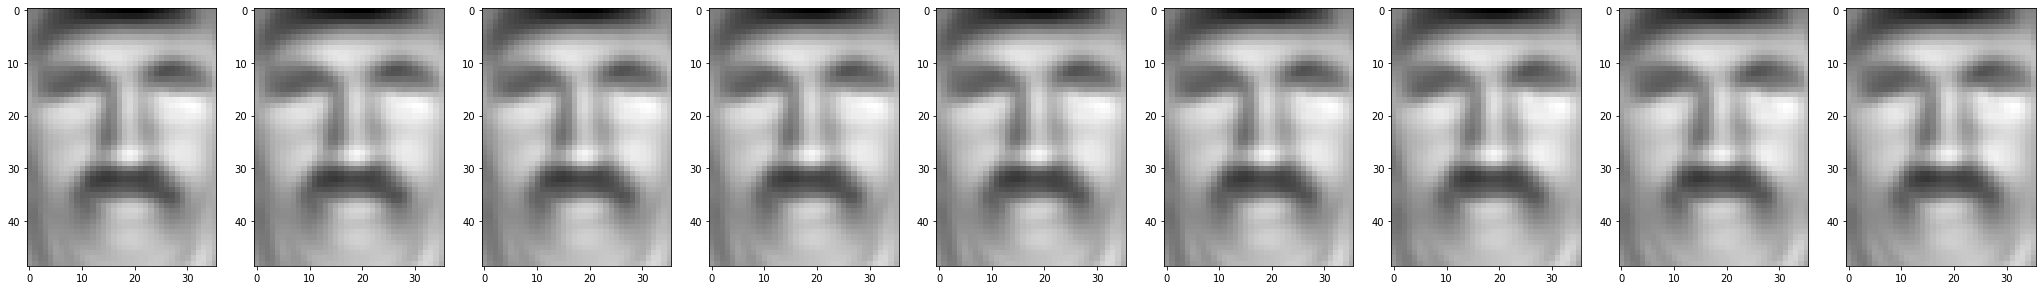

In [17]:
evolution(all_faces[3])    ### MALE

REMARK: 
Notice how the beard arrives only with the 24th feature

### Exercise 2: Exploring the Fairness of PCA

Now, we want to verify the claim in the paper [2] we have mentioned before. Load the file `sex.txt` in the same directory as the images, then partition the original images $\mathbf{X}$ into two groups based on that. Check also which labels in `sex.txt` is for "male" and "female" respectively.

In [18]:
sex = np.genfromtxt('data/images/sex.txt')
### 1 for male / 0 for female
male = np.where(sex==1) 
fem  = np.where(sex==0)
### split
males   = all_faces[male]
females = all_faces[fem]

print(males.shape)
print(females.shape)

(10270, 1764)
(2962, 1764)


Plot the reconstruction errors for $k = 1, \dots, 20$ of both groups in a single plot. Do you notice anything?

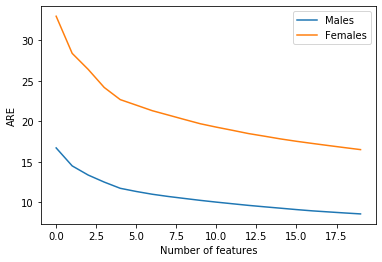

In [19]:
ARE(males, eigvectors, 'Males', 20)
ARE(females, eigvectors, 'Females', 20)
AREplot()

One might argue that this problem is because of the difference in the number of samples of male and female images in the dataset. To verify this, sample 1000 images from the set of female images and another 1000 images from the set of male images. Plot the reconstruction error as before using these samples. 

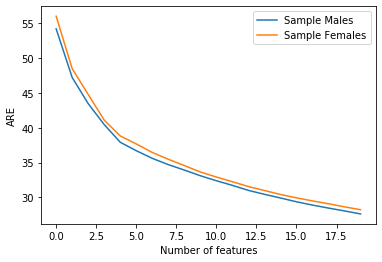

In [20]:
ARE(  males[:1000], eigvectors , 'Sample Males'  , 20)
ARE(females[:1000], eigvectors , 'Sample Females', 20)
AREplot()

If you have followed everything so far, congratulations, you have just verified the claim of a recent research paper from a famous conference!

---

You may wonder how this unfairness comes about. The original paper makes no argument to this end, it just notes the unfairness. Can you come up with a good explanation by exploring the data and the principled components? This is an open-ended exercise. Here are a few first ideas:
* Check out the principal components you would get when doing PCA on *only* the female or male faces, respectively, and compare them to the PC’s of the joint dataset. 
* Try sorting the (male and female) images by their reconstruction error using $M$ principal components. Do you notice a qualitative difference between the badly-reconstructed and well-reconstructed images? 
* Make a scatter-plot of the projected data in the 2D plane using the 1st-2nd, 3rd-4th, 5th-6th principal components, scaling the dots by their reconstruction error (and using color to identify gender). Do you see structure?

If you think you find a good explanation, clean up your notebook and send it to us. If we get a particularly good answer (or several), we will forward them to the original authors. 

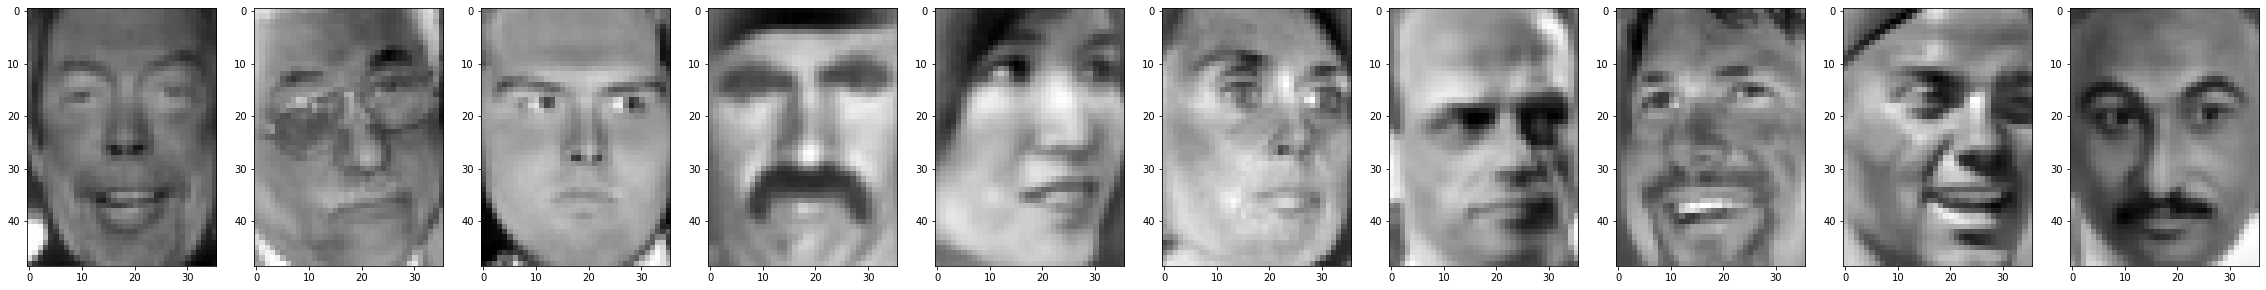

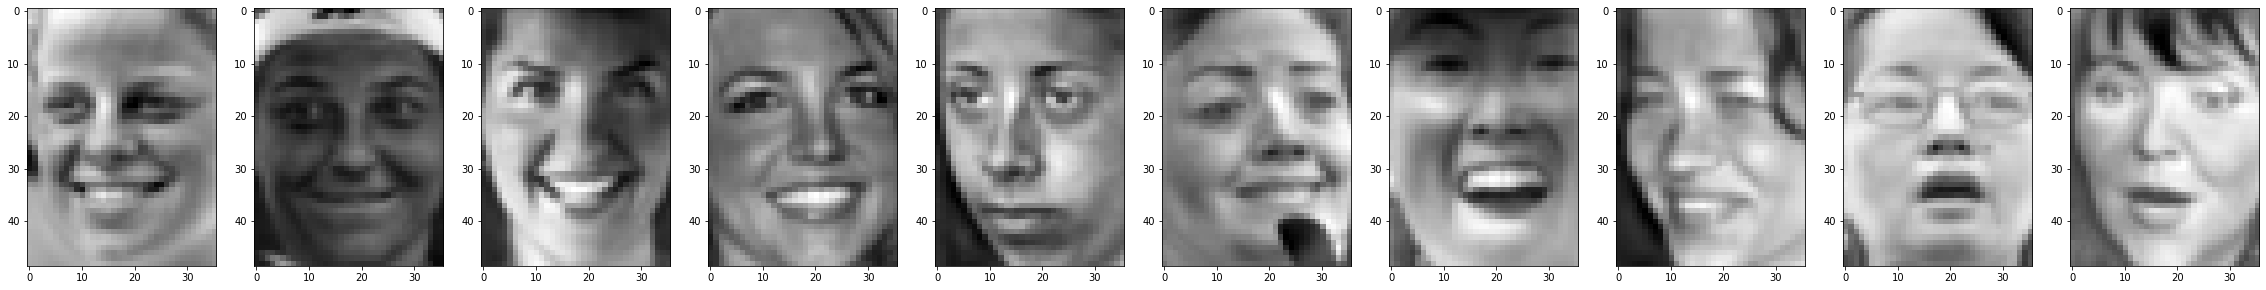

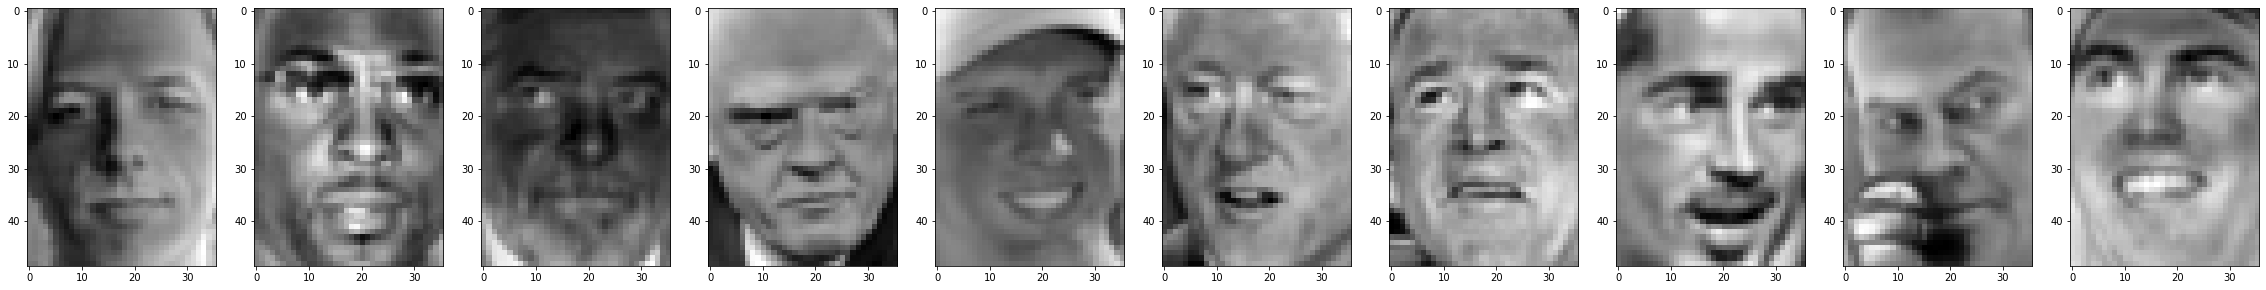

In [21]:
show(all_faces[:10])
show(females[100:110])
show(males[50:60])

In [22]:
U_m = PCA(males[:2500])
U_f = PCA(females[:2500]) 
joint = np.concatenate([females[:2500], males[:2500]])
U_j = PCA(joint)

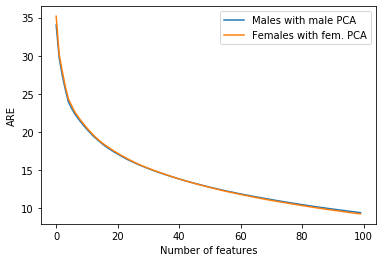

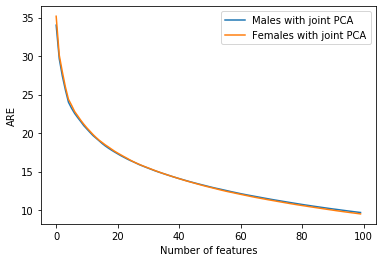

In [24]:
male_male  = ARE( males[:2500] , U_m , 'Males with male PCA'  , 100)
fem_fem    = ARE(females[:2500], U_f , 'Females with fem. PCA', 100)
AREplot()
male_joint = ARE( males[:2500] , U_j , 'Males with joint PCA'  , 100)
fem_joint  = ARE(females[:2500], U_j , 'Females with joint PCA', 100)
AREplot()

## Conclusion:

### After some analysis I have come to the conclusion that PCA has no bias against females. The difference of reconstruction errors was in fact caused by the majority of datapoints being men. When I did PCA on a dataset with each 2500 men and women the effect vanished (as shown in the plot above). In fact, one can now see a slight advantage for the women. 

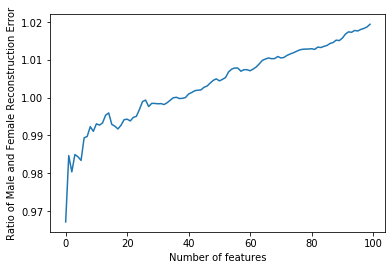

In [28]:
plt.plot(male_joint/fem_joint)
plt.ylabel('Ratio of Male and Female Reconstruction Error')
plt.xlabel('Number of features')
plt.show()

### Bonus 1: An alternative derivation of PCA

In the lecture, we have seen how PCA is derived. Given a dataset $\mathbf{X} := (\mathbf{x}_1, \dots, \mathbf{x}_N)^\top \in \mathbb{R}^{N \times D}$ where $\mathbf{x}_i \in \mathbb{R}^D$ for all $i = 1, \dots, N$, its goal is to find the orthogonal matrix $\mathbf{U} \in \mathbb{R}^{D \times M}$ with $M < D$ such that the following reconstruction error is minimized
$$
\begin{align}
    J(\mathbf{U}) = \frac{1}{N} \sum_{n=1}^N \Vert \mathbf{x}_n - \tilde{\mathbf{x}}_n \Vert^2 \, ,
\end{align}
$$
where $\tilde{\mathbf{x}}_n$ is the $n$th row of the reconstruction $\tilde{\mathbf{X}} = (\mathbf{X}\mathbf{U}) \mathbf{U}^\top$. Thus, PCA can be seen as an autoencoder without nonlinearities. In this exercise, we will see an **alternative** way for deriving PCA, based on a (projected) variance maximization. 

---

We will start with the case when we project our data to a one-dimensional space (a line,  $M=1$). In this case, we write the projection as a vector $\mathbf{u} \in \mathbb{R}^D$ and let $\mathbf{z} := (z_n = \mathbf{x}_n^\top \mathbf{u})_{n=1}^N$ be the set of projections. Our goal is to find $\mathbf{u}$ such that the variance of these projections is maximized. Therefore, write down the formula for the mean and variance of $\mathbf{z}$ in term of $z_n$ below. **Hint:** use summations.

$$\bar{z} = \dots$$

$$\mathrm{Var} \, \mathbf{z} = \dots$$

Next, we let $\bar{\mathbf{x}} := \frac{1}{N} \sum_{n=1}^N \mathbf{x}_n$. Write down the mean and variance in term of $\mathbf{x}_n^\top \mathbf{u}$. **Hint:** use summations.

$$
\bar{y} = \dots
$$

$$
\mathrm{Var} \, \mathbf{z} = \dots
$$

We now let $\hat{\mathbf{X}} := (\mathbf{x}_1 - \bar{\mathbf{x}}, \dots, \mathbf{x}_N - \bar{\mathbf{x}})^\top$ be an $\mathbb{R}^{N \times D}$ matrix. Furthermore, we let the matrix
$$
\mathbf{S} := \frac{1}{N} \hat{\mathbf{X}}^\top \hat{\mathbf{X}}
$$
be the $D \times D$ data covariance matrix. Write down the variance above in term of $\mathbf{S}$.

$$
\mathrm{Var} \, \mathbf{z} = \dots
$$

We are now ready to find the principal component $\mathbf{u}_1$. Recall, our goal to maximize the variance above, so write down the objective function in term of $\mathbf{u}$ below.

$$
\begin{align}
    \mathbf{u}_1 = &\dots \\
            &\text{s.t.} \enspace \mathbf{u}^\top \mathbf{u} = 1
\end{align}
$$

Why do we have the constraint $\mathbf{u}^\top \mathbf{u} = 1$?

Since we have the previous constraint, we need to write down the Lagrangian so that the previous constrained problem becomes an unconstrained one. Let the Lagrange multiplier be $\lambda$. Write down the unconstrained problem.

$$
\mathbf{u}_1 = 
$$

Now, as usual, to solve this problem, we just need to set the derivative (w.r.t. $\mathbf{u}$) of the above problem to zero. What do you get? What can you conclude about $\mathbf{u}$ from the equation you've just found? **Hint:** the last equation should be an eigenvalue equation.

$$
\begin{align}
    \dots &= 0 \\
    \dots &= \dots
\end{align}
$$

Finally, from the last equation, left-multiply both sides with $\mathbf{u}^\top$. What do you get?

$$
\dots = \dots
$$

What can you conclude about $\lambda$, and therefore what can you conclude about $\mathbf{u}_1$?

### Bonus 2: Multiple principlal components

We can generalize our PCA, where we need to find the $D \times M$ matrix
$$
\mathbf{U} = \begin{pmatrix}
\mathbf{u_1} \dots
\mathbf{u_M}
\end{pmatrix} \, .
$$
We have already gotten the first component $\mathbf{u}_1$ in the previous exercise. We are now interested in finding $\mathbf{u}_2, \dots, \mathbf{u}_M$. We can find them by assuming that they are orthonormal to each other. That is, $\mathbf{u}_i^\top \mathbf{u}_j$ is equal to one if $i = j$ and is equal to zero if $i \neq j$.

Write down the optimization problem for the second component $\mathbf{u}_2$ by following the previous exercise and the constraint that we have just discussed.

$$
\begin{align}
    \mathbf{u}_2 = \, &\mathrm{argmax} \dots \\
            &\text{s.t.} \enspace \dots 
\end{align}
$$

Can you solve this problem? **Hint:** Use two Lagrange multipliers and follow the previous exercise. Solve the those multipliers one by one.

_(Your answer here)_

Finally, we use induction to get the $i$th principal component for each $i = 3, \dots, M$. Can you write down what is the optimization problem for it?

$$
\begin{align}
    \mathbf{u}_i = \, &\mathrm{argmax} \dots \\
            &\text{s.t.} \enspace \dots 
\end{align}
$$